# **GNNS 1**

1 Two-dimensional data

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import matplotlib.patches as patches
from matplotlib.colors import LogNorm


In [14]:
def generate_moons_data(n_samples=500, noise=0.1):
    X, y = make_moons(n_samples=n_samples, noise=noise)
    return X

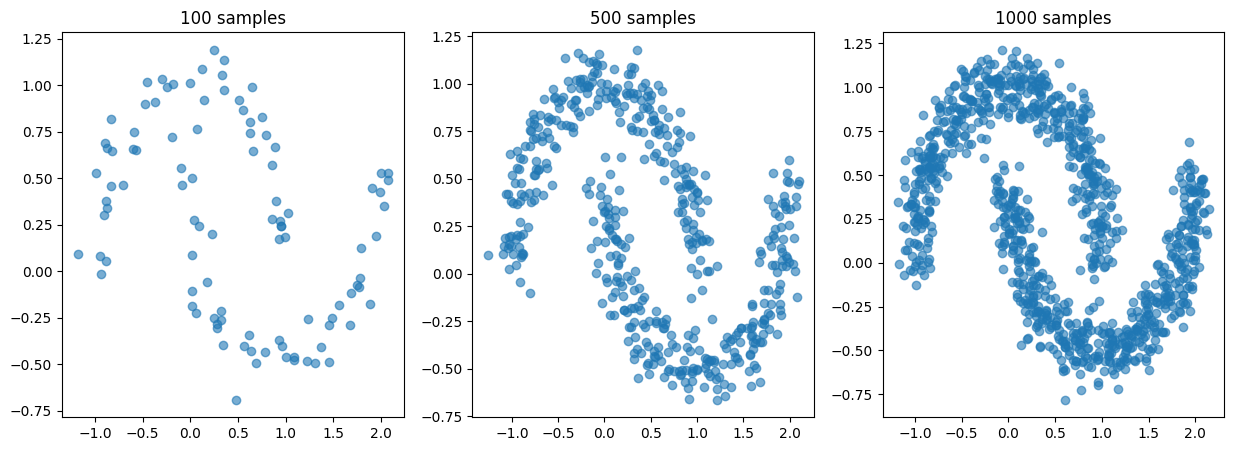

In [15]:
sample_sizes = [100, 500, 1000]
datasets = [generate_moons_data(n) for n in sample_sizes]

plt.figure(figsize=(15, 5))
for i, data in enumerate(datasets):
    plt.subplot(1, len(datasets), i+1)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.6)
    plt.title(f"{sample_sizes[i]} samples")
plt.show()

In [16]:
# Histogram
def histogram_density(X, bin_size=10):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    x_bins = np.linspace(x_min, x_max, bin_size)
    y_bins = np.linspace(y_min, y_max, bin_size)

    density, _, _ = np.histogram2d(X[:, 0], X[:, 1], bins=[x_bins, y_bins], density=True)

    def evaluate_density(x, y):
        x_idx = np.digitize(x, x_bins) - 1
        y_idx = np.digitize(y, y_bins) - 1
        if x_idx >= 0 and x_idx < bin_size and y_idx >= 0 and y_idx < bin_size:
            return density[x_idx, y_idx]
        else:
            return 0.0

    return density, evaluate_density



In [17]:
def histogram_density(X, bin_size=10):
    # Set up the bins
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    x_bins = np.linspace(x_min, x_max, bin_size + 1)
    y_bins = np.linspace(y_min, y_max, bin_size + 1)

    density, _, _ = np.histogram2d(X[:, 0], X[:, 1], bins=[x_bins, y_bins], density=True)

    def evaluate_density(point):
        x, y = point
        x_idx = np.digitize(x, x_bins) - 1
        y_idx = np.digitize(y, y_bins) - 1

        # ensure indices are within bounds
        if x_idx < 0 or x_idx >= density.shape[0] or y_idx < 0 or y_idx >= density.shape[1]:
            return 0.0
        else:
            return density[x_idx, y_idx]

    return density, evaluate_density


In [18]:
# Single Gaussian
def single_gaussian_density(X):
    mean = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)

    def evaluate_density(x):
        x_m = x - mean
        return np.exp(-0.5 * x_m.T @ np.linalg.inv(cov) @ x_m) / (2 * np.pi * np.sqrt(np.linalg.det(cov)))

    return mean, cov, evaluate_density



In [19]:
# GMM
'''
def gaussian_mixture_density(X, n_components=3, n_iter=100):
    # initialize randomly
    np.random.seed(10) # set seed for reproducability
    n, d = X.shape
    weights = np.ones(n_components) / n_components
    means = X[np.random.choice(n, n_components, replace=False)]
    covariances = np.array([np.eye(d)] * n_components)

    for _ in range(n_iter):
        responsibilities = np.zeros((n, n_components))
        for k in range(n_components):
            diff = X - means[k]
            responsibilities[:, k] = weights[k] * np.exp(-0.5 * np.sum(diff @ np.linalg.inv(covariances[k]) * diff, axis=1))
            responsibilities[:, k] /= np.sqrt((2 * np.pi)**d * np.linalg.det(covariances[k]))

        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        # update weights, means, covariances
        weights = responsibilities.mean(axis=0)
        for k in range(n_components):
            Nk = responsibilities[:, k].sum()
            means[k] = (X * responsibilities[:, k][:, np.newaxis]).sum(axis=0) / Nk
            diff = X - means[k]
            covariances[k] = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff / Nk + 1e-6 * np.eye(d)

    def evaluate_density(x):
        prob = 0
        for k in range(n_components):
            diff = x - means[k]
            prob += weights[k] * np.exp(-0.5 * diff.T @ np.linalg.inv(covariances[k]) @ diff) / np.sqrt((2 * np.pi)**d * np.linalg.det(covariances[k]))
        return prob

    return weights, means, covariances, evaluate_density
'''
def gaussian_mixture_density(X, n_components=3, n_iter=100):
    # Set seed for reproducibility
    np.random.seed(10)
    n, d = X.shape

    weights = np.ones(n_components) / n_components
    means = X[np.random.choice(n, n_components, replace=False)]
    covariances = np.array([np.eye(d)] * n_components)
    for _ in range(n_iter):
        responsibilities = np.zeros((n, n_components))

        for k in range(n_components):
            diff = X - means[k]
            responsibilities[:, k] = weights[k] * np.exp(-0.5 * np.sum(diff @ np.linalg.inv(covariances[k]) * diff, axis=1)) #CH

            responsibilities[:, k] /= np.sqrt((2 * np.pi)**d * np.linalg.det(covariances[k]))

        # normalize
        responsibilities /= (responsibilities.sum(axis=1, keepdims=True) + 1e-10)


        # update weights, means, covs
        weights = responsibilities.mean(axis=0)
        for k in range(n_components):
            Nk = responsibilities[:, k].sum()
            means[k] = (X * responsibilities[:, k][:, np.newaxis]).sum(axis=0) / Nk
            diff = X - means[k]
            covariances[k] = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff / Nk + 1e-6 * np.eye(d)  # Add small value to covariance matrix for numerical stability

    def evaluate_density(x):
        prob = 0
        for k in range(n_components):
            diff = x - means[k]
            prob += weights[k] * np.exp(-0.5 * diff.T @ np.linalg.inv(covariances[k]) @ diff) / np.sqrt((2 * np.pi)**d * np.linalg.det(covariances[k]))
        return prob

    return weights, means, covariances, evaluate_density


In [20]:
# KDE
def kde_density(X, bandwidth=0.1):
    def kernel(x, y):
        return np.exp(-np.linalg.norm(x - y)**2 / (2 * bandwidth**2))

    #
    def evaluate_density(x):
        return np.mean([kernel(x, xi) for xi in X])

    return evaluate_density


In [21]:
# MMD metric
def mmd(X, Y, kernel):
    n, m = len(X), len(Y)
    K_XX = np.mean([kernel(x, x2) for x in X for x2 in X])
    K_YY = np.mean([kernel(y, y2) for y in Y for y2 in Y])
    K_XY = np.mean([kernel(x, y) for x in X for y in Y])
    return K_XX + K_YY - 2 * K_XY

def squared_exponential_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

def inverse_multi_quadratic_kernel(x, y, c=1.0):
    return 1 / np.sqrt(np.linalg.norm(x - y)**2 + c**2)


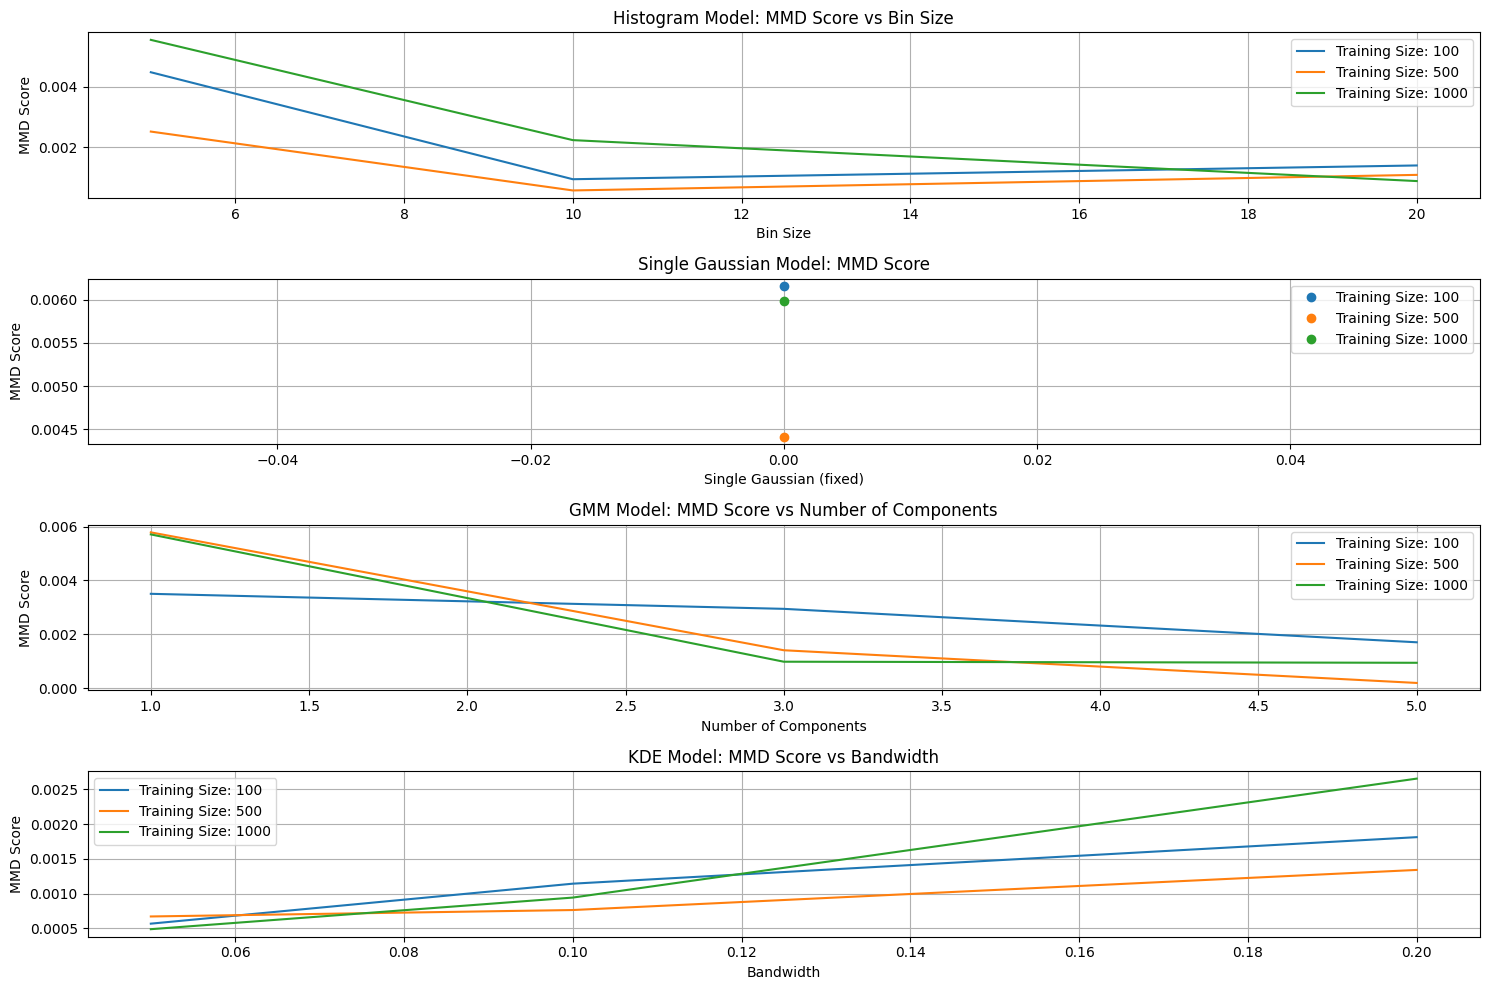

In [22]:
# parameters to test
sample_sizes = [100, 500, 1000]
histogram_bins = [5, 10, 20]
gmm_components = [1, 3, 5]
kde_bandwidths = [0.05, 0.1, 0.2]

mmd_results = {
    'Histogram': {size: [] for size in sample_sizes},
    'Single Gaussian':  {size: [] for size in sample_sizes},
    'GMM': {size: [] for size in sample_sizes},
    'KDE': {size: [] for size in sample_sizes}
}
'''
def sample_from_density(density_func, n_samples=500, x_min=-2, x_max=3, y_min=-2, y_max=3):
    samples = []
    while len(samples) < n_samples:
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(y_min, y_max)
        if np.random.rand() < density_func([x, y]):
            samples.append([x, y])
    return np.array(samples)
'''
def sample_from_density(density_func, n_samples=500, x_min=-2, x_max=3, y_min=-2, y_max=3, grid_size=100):

    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    X, Y = np.meshgrid(x_grid, y_grid)
    grid_points = np.vstack([X.ravel(), Y.ravel()]).T

    density_values = np.array([density_func(point) for point in grid_points])
    density_values = density_values / np.sum(density_values)  # normalize to get probabilities
    # Handle any NaN values in density_values
    if np.isnan(density_values).any() or np.sum(density_values) == 0:
        raise ValueError("Density values contain NaN or sum to zero")

    sampled_indices = np.random.choice(len(grid_points), size=n_samples, p=density_values)
    sampled_points = grid_points[sampled_indices]

    return sampled_points

test_data = generate_moons_data(500)

for size in sample_sizes:
    train_data = generate_moons_data(size)

    # Histogram Model - Varying Bin Size
    for bin_size in histogram_bins:
        _, density_func = histogram_density(train_data, bin_size=bin_size)
        generated_data = sample_from_density(density_func, n_samples=500)
        mmd_score = mmd(test_data, generated_data, squared_exponential_kernel)
        mmd_results['Histogram'][size].append((bin_size, mmd_score))

    # Single Gaussian Model
    mean, cov, density_func = single_gaussian_density(train_data)
    generated_data = sample_from_density(density_func, n_samples=500)
    mmd_score = mmd(test_data, generated_data, squared_exponential_kernel)
    mmd_results['Single Gaussian'][size].append((None, mmd_score))

    # GMM Model - Varying Number of Components
    for components in gmm_components:
        _, _, _, density_func = gaussian_mixture_density(train_data, n_components=components)
        generated_data = sample_from_density(density_func, n_samples=500)
        mmd_score = mmd(test_data, generated_data, squared_exponential_kernel)
        mmd_results['GMM'][size].append((components, mmd_score))

    # KDE Model - Varying Bandwidth
    for bandwidth in kde_bandwidths:
        density_func = kde_density(train_data, bandwidth=bandwidth)
        generated_data = sample_from_density(density_func, n_samples=500)
        mmd_score = mmd(test_data, generated_data, squared_exponential_kernel)
        mmd_results['KDE'][size].append((bandwidth, mmd_score))

plt.figure(figsize=(15, 10))

# Histogram model plot
plt.subplot(4, 1, 1)
for size in sample_sizes:
    bins, scores = zip(*mmd_results['Histogram'][size])
    plt.plot(bins, scores, label=f'Training Size: {size}')
plt.xlabel('Bin Size')
plt.ylabel('MMD Score')
plt.grid()
plt.title('Histogram Model: MMD Score vs Bin Size')
plt.legend()

# Single Gaussian model plot
plt.subplot(4, 1, 2)
for size in sample_sizes:
    scores = [mmd_results['Single Gaussian'][size][0][1] for _ in range(1)]  # No hyperparameter to vary
    plt.plot([0], scores, 'o', label=f'Training Size: {size}')  # Use a single point for each training size
plt.xlabel('Single Gaussian (fixed)')
plt.ylabel('MMD Score')
plt.grid()
plt.title('Single Gaussian Model: MMD Score')
plt.legend()

# GMM model plot
plt.subplot(4, 1, 3)
for size in sample_sizes:
    components, scores = zip(*mmd_results['GMM'][size])
    plt.plot(components, scores, label=f'Training Size: {size}')
plt.xlabel('Number of Components')
plt.ylabel('MMD Score')
plt.grid()
plt.title('GMM Model: MMD Score vs Number of Components')
plt.legend()

# KDE model plot
plt.subplot(4, 1, 4)
for size in sample_sizes:
    bandwidths, scores = zip(*mmd_results['KDE'][size])
    plt.plot(bandwidths, scores, label=f'Training Size: {size}')
plt.xlabel('Bandwidth')
plt.ylabel('MMD Score')
plt.grid()
plt.title('KDE Model: MMD Score vs Bandwidth')
plt.legend()

plt.tight_layout()
plt.show()


The MMD score for all plots goes down with increasing bandwidth, components etc. except for the KDE mode, where it goes up instead.

For the histogram, the MMD score is highest for a low number of bins but high number of samples, for the others the MMD score is highest for a low number of training samples.


THe lowest MMD scores seem to be:

Histogram: 10 bins with sample size 500

Single Gaussian: sample size 500

GMM: 1 component with sample size 100

KDE: bandwith 0.1 with sample size 100


The highest MMD scores on the other hand are

Histogram: < 6 bins with sample size 1000

GMM: 5 components with sample size 500

Single Gaussian: sample size 100

KDE: bandwith 0.2 with sample size 100

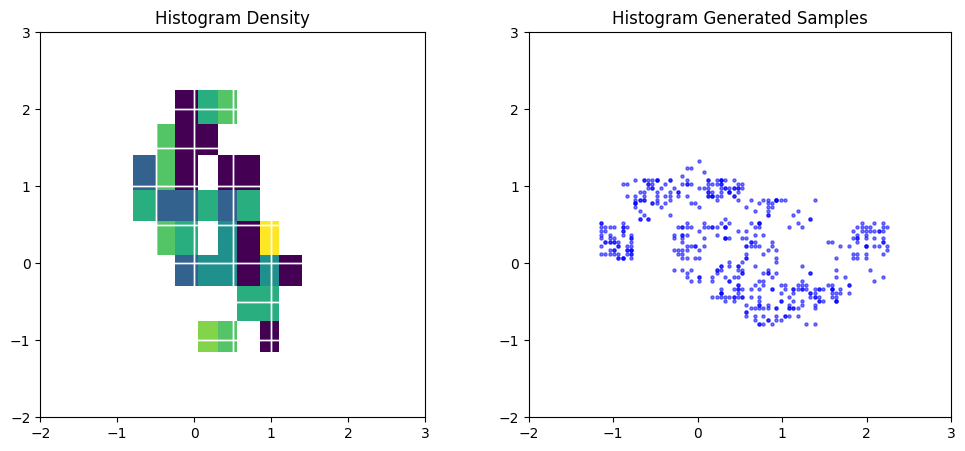

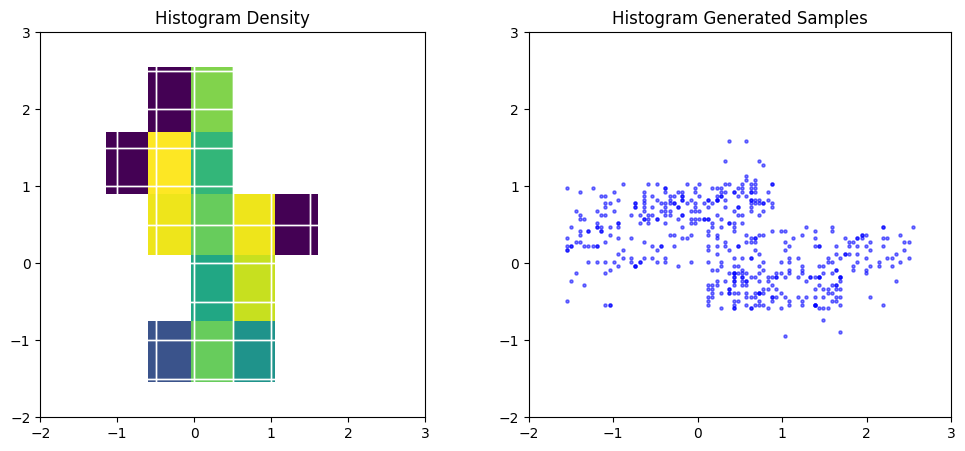

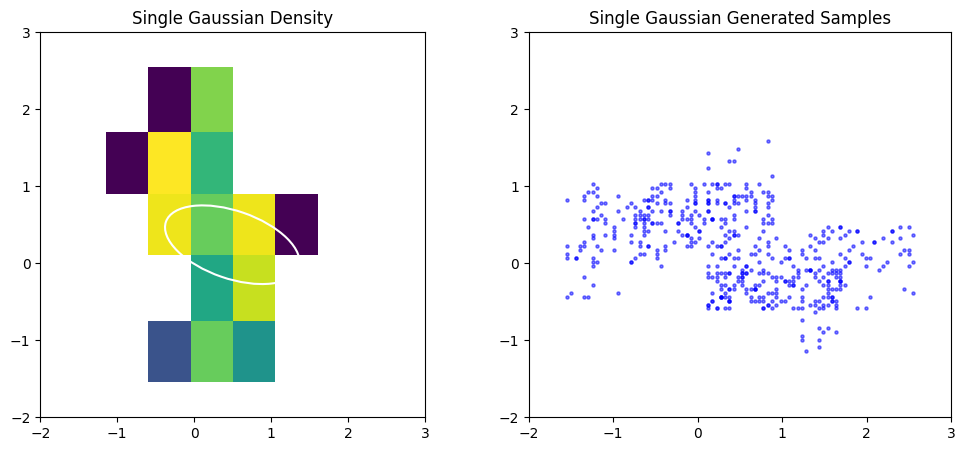

Means shape: (3,)
Covariances shape: [(2,), (2,), (2,)]
Unexpected mean shape: ()
Unexpected mean shape: ()
Unexpected mean shape: ()


<ipython-input-23-0148638111ff>:48: RuntimeWarning: invalid value encountered in sqrt
  width, height = 2 * np.sqrt(eigenvalues)


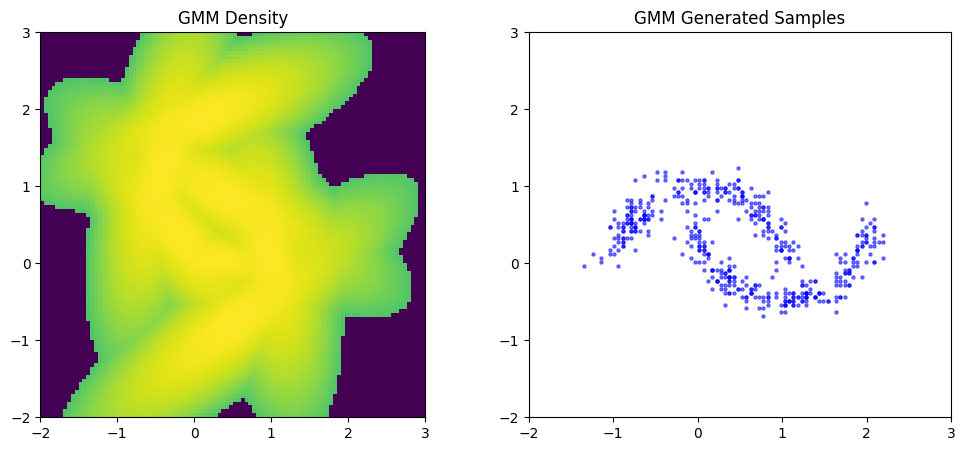

Means shape: (3,)
Covariances shape: [(2,), (2,), (2,)]
Unexpected mean shape: ()
Unexpected mean shape: ()
Unexpected mean shape: ()


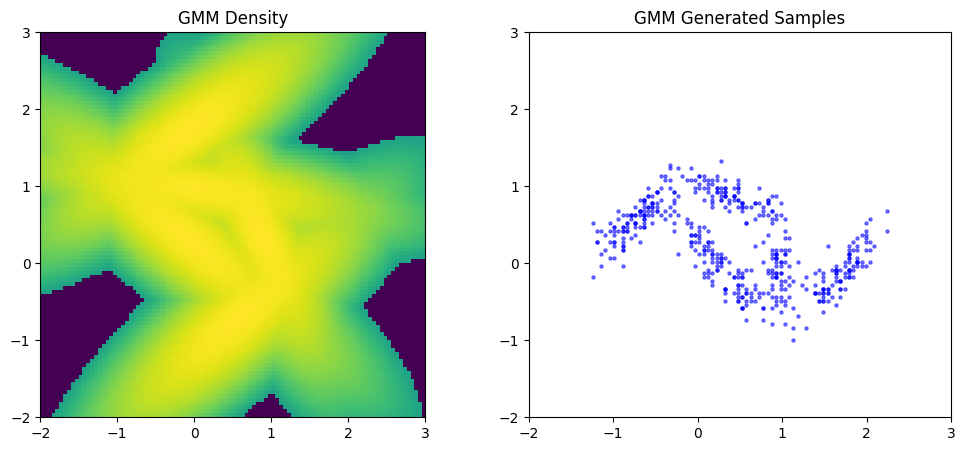

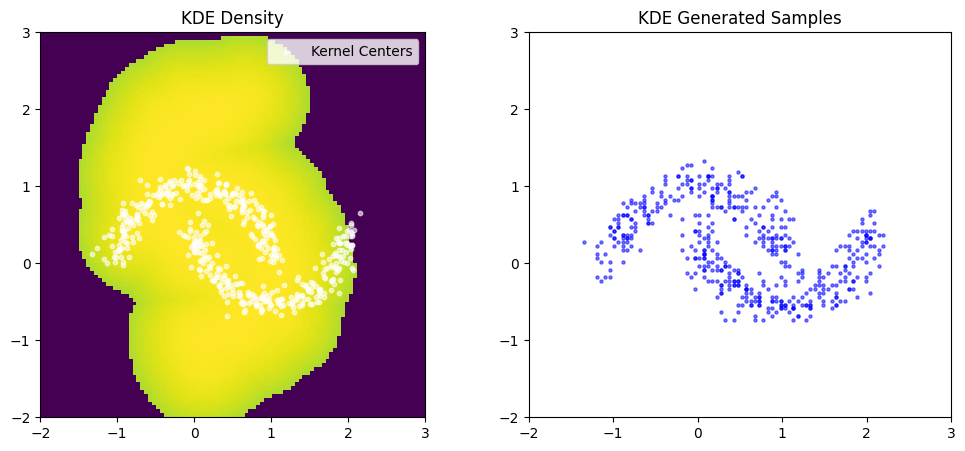

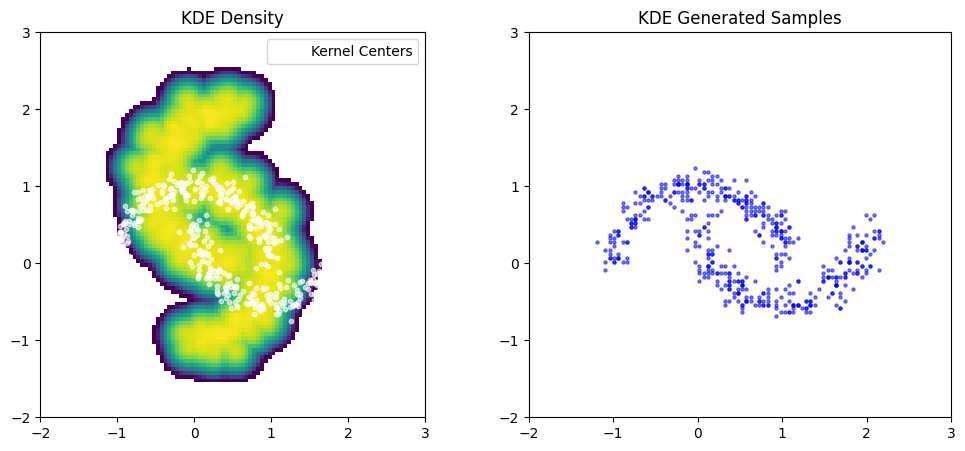

In [23]:
x_grid = np.linspace(-2, 3, 100)
y_grid = np.linspace(-2, 3, 100)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
grid_points = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T

def plot_density_and_samples(model_name, density_func, generated_data, train_data=None):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    density_values = np.array([density_func(point) for point in grid_points]).reshape(100, 100)
    ax[0].imshow(density_values.T, origin='lower', extent=(-2, 3, -2, 3), norm=LogNorm(), cmap='viridis')
    ax[0].set_title(f'{model_name} Density')

    if model_name == 'Histogram':
        bin_size = 10
        for i in range(bin_size):
            for j in range(bin_size):
                rect = patches.Rectangle((-2 + i * 5 / bin_size, -2 + j * 5 / bin_size), 5 / bin_size, 5 / bin_size,
                                         linewidth=1, edgecolor='white', facecolor='none')
                ax[0].add_patch(rect)

    elif model_name == 'Single Gaussian' and train_data is not None:
        mean, cov, _ = single_gaussian_density(train_data)

        if cov.ndim == 1:
            cov = np.diag(cov)

        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues)

        if mean.ndim == 1 and mean.shape[0] == 2:
            ellipse = patches.Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='white', facecolor='none', lw=1.5)
            ax[0].add_patch(ellipse)

    elif model_name == 'GMM' and train_data is not None:
        means, covariances = gaussian_mixture_density(train_data, n_components=3)[:2]  # Assuming 3 components

        print("Means shape:", means.shape)
        print("Covariances shape:", [cov.shape for cov in covariances])

        for mean, cov in zip(means, covariances):
            # ensure covariance is 2D
            if cov.ndim == 1:
                cov = np.diag(cov)  # convert 1D covariance to 2D diagonal matrix if necessary

            eigenvalues, eigenvectors = np.linalg.eigh(cov)  # Decomposition for ellipse
            angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
            width, height = 2 * np.sqrt(eigenvalues)

            # check mean for correct dimensionality
            if mean.ndim == 1 and mean.shape[0] == 2:
                ellipse = patches.Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='white', facecolor='none', lw=1.5)
                ax[0].add_patch(ellipse)
            else:
                print(f"Unexpected mean shape: {mean.shape}")

    elif model_name == 'KDE' and train_data is not None:
        ax[0].scatter(train_data[:, 0], train_data[:, 1], s=10, c='white', alpha=0.6, label='Kernel Centers')
        ax[0].legend()

    ax[1].scatter(generated_data[:, 0], generated_data[:, 1], color='blue', alpha=0.5, s=5)
    ax[1].set_xlim(-2, 3)
    ax[1].set_ylim(-2, 3)
    ax[1].set_title(f'{model_name} Generated Samples')
    plt.show()

good_bad_models = [
    ('Histogram', 10, 100),
    ('Histogram', 5, 100),
    ('Single Gaussian', None, 500),
    ('GMM', 7, 500),
    ('GMM', 5, 500),
    ('KDE', 0.1, 500),
    ('KDE', 0.05, 500)
]

for model_name, hyperparam, size in good_bad_models:
    train_data = generate_moons_data(size)

    if model_name == 'Histogram':
        _, density_func = histogram_density(train_data, bin_size=hyperparam)
    elif model_name == 'GMM':
        _, _, _, density_func = gaussian_mixture_density(train_data, n_components=hyperparam)
    elif model_name == 'KDE':
        density_func = kde_density(train_data, bandwidth=hyperparam)

    generated_data = sample_from_density(density_func, n_samples=500)

    plot_density_and_samples(model_name, density_func, generated_data, train_data)


**Histogram**

THe density plot is blocky, showing discrete bins. This approach is simple but kind of loses fine details since it doesn't smooth across the grid boundaries. It captures the basic area of data concentration but lacks smoothness and has noticeable block artifacts. The samples cover the general area but have a very uniform distribution within each bin and the generated points may appear unnaturally clustered in squares or rectangles. Overall, the histograms seem to work well for very simple density estimation but struggle with complex shapes and details.


**Single Gaussian**

A single Gaussian, while being simple in terms of implementation, will not be able to capture the bi-modal structure of the two moons effectively. It places a high density around the center of the moons without the distinct separation between the two, and the generated samples cluster around the center as well.

**GMM**

The density plot from GMM is smooth and continuous and captures some of the overall structure but with very round Gaussian-like regions. The generated samples show some clustering along the moons, with better results with 5+ components.

**KDE**

The density plot is smooth and detailed. The generated samples closely match the actual distribution of the two moons, and smooth continuous nature of KDE helps capture the shape well. The samples of KDE seem to follow the curved shape most accurately of all the models. However, it depends on bandwidth selection, since a smaller bandwidth might capture detail, while a larger one could oversmooth the distribution.

<div style="color: green; font-weight:bold">Comment</div>

- The MMD is a maximum over the kernels, but here it seems that the mmd is calculated only for one kernel (and hence wouldn't be a maximum). Additionally, it's the MMD Squared that's calculated, not the MMD. 
- Histogram: Other than slight bin boundary definition differences, the density implementation looks essentially the same as the model solution. I'm not totally convinced by the sampling, though; a grid size of 100 even for the interval (-2,2) isn't very fine and makes the density look more discrete than I believe appropriate. This comment will hold for all models I think the model solution's method of sampling along the grid lines and then adding noise is preferable.  

- Single Gaussian: The fitting looks essentially very good. I believe sampling via an inverse transform could be better than using the grid.
- GMM: The implementation looks very well optimised and essentially the same as the model solution. Sampling by choosing a component and then an inverse transform could be better than using the grid.
- KDE: The fitting looks very appropriate. Sampling a point could be done as follows: Choose a random point within the training set and then sampling using a normal distribution centered at that point with bandwidth given as a hyperparameter.

- The plotting is very difficult to interpret on account of the color and the sampling functions seem to somehow be rotated by 90 degrees. Flipping the coordinate axes would fix this (though checking why they're lfipped in the first place would be valuable). The single gausian density seems also repeats the histogram density and the sampling seems similarly affected. 

The densities and samplings seem to be quite well implemented, but the plotting has some issues.

2 Higher-dimensional Data

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier
!pip install quantile-forest
import quantile_forest
#from quantile_forest import QuantileForest
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.7 MB/s eta 0:00:00


In [25]:
digits = load_digits()
X = digits.data
y = digits.target


np.random.seed(10)
indices = np.random.permutation(len(X))
train_size = int(len(X) * 0.7)
train_indices, test_indices = indices[:train_size], indices[train_size:]
train_data, test_data = X[train_indices], X[test_indices]



In [26]:
def mmd(X, Y, kernel_func):
    XX = kernel_func(X, X)
    YY = kernel_func(Y, Y)
    XY = kernel_func(X, Y)
    return XX.mean() + YY.mean() - 2 * XY.mean()

def squared_exponential_kernel(X, Y, sigma=1.0):
    pairwise_sq_dists = cdist(X, Y, 'sqeuclidean')
    return np.exp(-pairwise_sq_dists / (2 * sigma ** 2))

In [27]:
# Model 1: Density Forest
def density_forest_density(train_data):
    density_forest = quantile_forest.RandomForestQuantileRegressor()
    density_forest.fit(train_data, np.ones(len(train_data)))
    return density_forest

# Model 2: Single Gaussian
def single_gaussian_density(train_data):
    mean = np.mean(train_data, axis=0)
    cov = np.cov(train_data, rowvar=False)
    return lambda X: multivariate_normal.pdf(X, mean=mean, cov=cov)

# Model 3: GMM
def gmm_density(train_data, n_components=10):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(train_data)
    return gmm

# Model 4: KDE
def kde_density(train_data, bandwidth=0.5):
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(train_data)
    return kde

In [28]:
def generate_samples(model, n_samples=500, model_type=""):
    if model_type == "DensityForest":
        indices = np.random.choice(len(train_data), n_samples)
        return train_data[indices]
    elif model_type == "SingleGaussian":
        mean = np.mean(train_data, axis=0)
        cov = np.cov(train_data, rowvar=False)
        return np.random.multivariate_normal(mean, cov, n_samples)
    elif model_type == "GMM":
        return model.sample(n_samples)[0]
    elif model_type == "KDE":
        return model.sample(n_samples)

In [29]:
# evaluate models with MMD for each
n_samples = 500
models = {
    "DensityForest": density_forest_density(train_data),
    "SingleGaussian": single_gaussian_density(train_data),
    "GMM": gmm_density(train_data, n_components=10),
    "KDE": kde_density(train_data, bandwidth=0.5)
}

mmd_results = {}
for model_name, model in models.items():
    generated_data = generate_samples(model, n_samples=n_samples, model_type=model_name)
    mmd_score = mmd(test_data, generated_data, squared_exponential_kernel)
    mmd_results[model_name] = mmd_score
    print(f"{model_name} MMD Score: {mmd_score}")

DensityForest MMD Score: 0.004715851851851851
SingleGaussian MMD Score: 0.003851851851851852
GMM MMD Score: 0.003851851851851852
KDE MMD Score: 0.003851853808256851


DensityForest generated digit distribution: {0: 48, 1: 51, 2: 43, 3: 56, 4: 48, 5: 56, 6: 62, 7: 55, 8: 41, 9: 40}
SingleGaussian generated digit distribution: {0: 39, 1: 13, 2: 55, 3: 33, 4: 44, 5: 37, 6: 44, 7: 44, 8: 114, 9: 77}
GMM generated digit distribution: {0: 39, 1: 42, 2: 53, 3: 41, 4: 48, 5: 46, 6: 55, 7: 49, 8: 75, 9: 52}
KDE generated digit distribution: {0: 37, 1: 55, 2: 54, 3: 56, 4: 34, 5: 49, 6: 70, 7: 36, 8: 64, 9: 45}


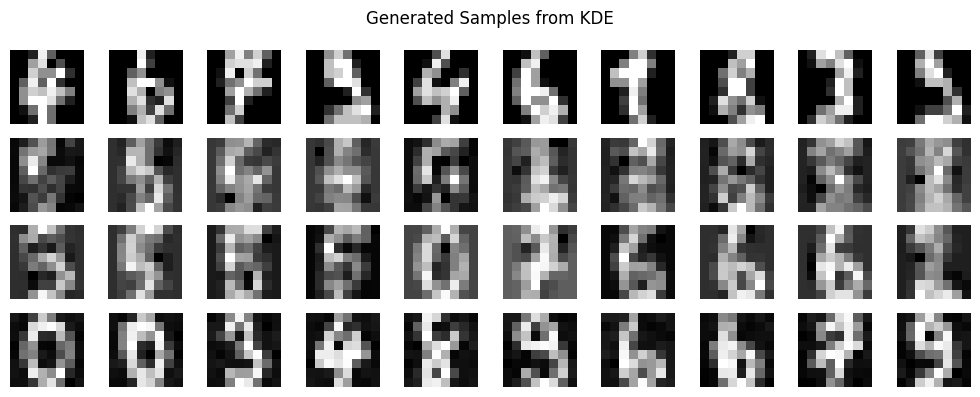

In [30]:
# RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=10)
rf_classifier.fit(train_data, y[train_indices])

for model_name, model in models.items():
    generated_data = generate_samples(model, n_samples=n_samples, model_type=model_name)
    predicted_labels = rf_classifier.predict(generated_data)
    unique, counts = np.unique(predicted_labels, return_counts=True)
    print(f"{model_name} generated digit distribution:", dict(zip(unique, counts)))

plt.figure(figsize=(10, 4))
for i, (model_name, model) in enumerate(models.items()):
    generated_data = generate_samples(model, n_samples=10, model_type=model_name)
    for j, digit_sample in enumerate(generated_data[:10]):
        plt.subplot(4, 10, i * 10 + j + 1)
        plt.imshow(digit_sample.reshape(8, 8), cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Generated Samples from {model_name}")
plt.tight_layout()
plt.show()

<div style="color: green; font-weight:bold">Comment</div>

- The same comment about MMD applies.
- The random quantile density forest just takes $n$ random data points from the training set; this isn't actually using the density forest. A more appropriate implementation would be to take a random tree, choose a leaf node weighted by where the training data ends up, and sample randomly at uniform from within the box that that leaf corresponds to.
- There is some code inefficiency and evaluation strangeness that samples are repeatedly generated; it may have been worth storing them somewhere so that all evaluation and visualisation is on the same data.
- The random forest is only used to obtain the distribution of predicted numbers, but this doesn't reflect the quality of the generated data. I would have been interested to see how the random forest predictions align with what the images are _supposed_ to be.